In [1]:
import os
import time
import shutil
import pickle

import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from tensorboard_logger import configure, log_value

from model import RecurrentAttention
from utils import AverageMeter

from torchvision import transforms, utils, models
from PIL import Image

import torch

import utils
# import data_loader

from trainer import Trainer
from config import get_config

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd

import json

In [2]:
def load_inputs(impath):
    to_tens = transforms.ToTensor()
    return to_tens(Image.open(impath).convert('RGB')).unsqueeze(0)

In [3]:
m = open("../../pooling/data/migration_data.json",)
mig_data = json.load(m)
m.close()
mig_data = pd.DataFrame.from_dict(mig_data, orient = 'index').reset_index()
mig_data.columns = ['muni_id', 'num_migrants']
q = 4
mig_data['class'] = pd.qcut(mig_data['num_migrants'], q = q, labels = [i for i in range(q)])
mig_data

,muni_id,num_migrants,class
0,484001001,42055.0,3
1,484001002,4017.0,3
2,484001003,11992.0,3
3,484001004,762.0,2
4,484001005,7551.0,3
...,...,...,...
2326,484032049,2487.0,3
2327,484032050,2024.0,3
2328,484032051,3084.0,3
2329,484032052,2919.0,3


In [4]:
mig_data['class'].value_counts()

0    583
1    583
2    583
3    582
Name: class, dtype: int64

In [5]:
def get_png_names(directory):
    images = []
    for i in os.listdir(directory):
        try:
            if os.path.isdir(os.path.join(directory, i)):
                new_path = os.path.join(directory, i, "pngs")
                image = os.listdir(new_path)[0]
                images.append(os.path.join(directory, i, "pngs", image))
        except:
            pass
    return images


            

image_names = get_png_names("../../attn/data/MEX/")

y_class, y_mig = [], []

for i in image_names:
        dta = mig_data[mig_data["muni_id"] == i.split("/")[5]]
        if len(dta) != 0:
            y_class.append(dta['class'].values[0])
            y_mig.append(dta['num_migrants'].values[0])

In [7]:
import matplotlib.pyplot as plt
import torchvision
import random

train_num = int(25 * .70)

train_indices = random.sample(range(0, 25), train_num)
val_indices = [i for i in range(0, 25) if i not in train_indices]

In [8]:
import torchvision

batch_size = 1

# train = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(0, 93)]
# val = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(93, 133)]

# brighten = torchvision.transforms.functional.adjust_brightness(brightness_factor = 2)


train = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i]) for i in train_indices]
val = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i]) for i in val_indices]


train_dl = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)

In [9]:
# train_num = int(len(image_names) * .70)

# train_indices = random.sample(range(0, len(image_names)), train_num)
# val_indices = [i for i in range(0, len(image_names)) if i not in train_indices]


# batch_size = 1

# # train = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(0, 93)]
# # val = [(load_inputs(image_paths[i]).squeeze()[:, 0:28, 0:28], ys[i]) for i in range(93, 133)]

# train = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i]) for i in train_indices]
# val = [(torchvision.transforms.functional.adjust_brightness(load_inputs(image_names[i]), brightness_factor = 2).squeeze(), y_class[i], y_mig[i]) for i in val_indices]


# train_dl = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
# val_dl = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = True)


In [10]:
print("Num training: ", len(train_dl))
print("Num validation: ", len(val_dl))

Num training:  17
Num validation:  8


In [11]:
import numpy as np
from utils import plot_images

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [12]:
config, unparsed = get_config()

In [13]:
trainer = Trainer(config, (train_dl, val_dl))

H_g:  512


In [14]:
checkpoint = torch.load("./ckpt/ram_4_50x50_0.75_model_best.pth.tar")
checkpoint = checkpoint["model_state"]

In [18]:
trues, preds, classes = [], [], []

# for i,o,o2 in val_dl:

for im in image_names:
    
#     muni_id = im.split("/")[5]
    
    i = load_inputs(im)
    o = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['class'].values[0])
    o2 = torch.tensor(mig_data[mig_data["muni_id"] == im.split("/")[5]]['num_migrants'].values[0])
    
    pred = trainer.predict(1, i, o, o2, checkpoint).item()
    true = o2.item()
    
    trues.append(true)
    preds.append(pred)
    classes.append(o.item())
    
preds_df = pd.DataFrame()
preds_df['true'], preds_df['pred'], preds_df['class'] = trues, preds, classes
preds_df.head()

,true,pred,class
0,1446.0,288.490631,2
1,25.0,1879.818359,0
2,0.0,2381.429932,0
3,1559.0,304.903381,2
4,7551.0,2643.283936,3


Text(0, 0.5, 'True')

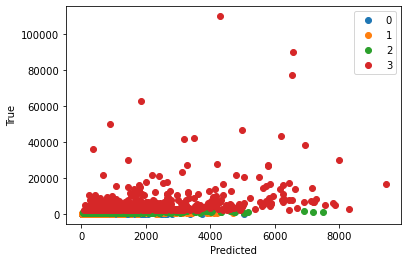

In [19]:
groups = preds_df.groupby("class")
for name, group in groups:
    plt.plot(group["pred"], group["true"], marker="o", linestyle="", label=name)
plt.legend()
plt.xlabel("Predicted")
plt.ylabel("True")

In [20]:
preds_df.to_csv("./preds_df_v5.csv")

Text(0, 0.5, 'True')

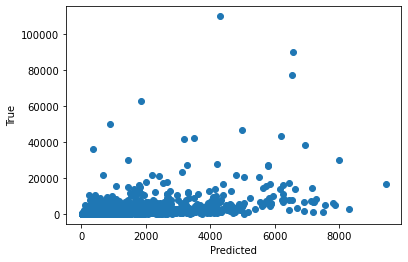

In [21]:
plt.scatter(preds_df['pred'], preds_df['true'])
plt.xlabel("Predicted")
plt.ylabel("True")

In [22]:
for name, group in groups:
    print(name, np.mean(abs(group["true"] - group["pred"])))

0 405.9097578784292
1 410.9002736947668
2 720.4285181792517
3 4445.117104079372


In [23]:
preds_df

,true,pred,class
0,1446.0,288.490631,2
1,25.0,1879.818359,0
2,0.0,2381.429932,0
3,1559.0,304.903381,2
4,7551.0,2643.283936,3
...,...,...,...
2061,2487.0,4230.448242,3
2062,2024.0,937.250671,3
2063,3084.0,1230.146484,3
2064,2919.0,2373.448242,3
